# Decision Trees - Datensatz ohne Feature `service`

In [16]:
import pandas as pd
import geopandas as gpd

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, median_absolute_error, make_scorer
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn import tree

# für Visualisierung
import matplotlib.pyplot as plt

In [3]:
# GeoJSON-Datei laden
gdf = gpd.read_file('../../../data/processed_data/simra_osm_no_service_all.geojson')

In [4]:
df = gdf.drop(columns=['markers', 'id', 'index_right', 'geometry', 'highway', 'incidents', 'rides', 'type'])

In [5]:
df.head(2)

,score,maxspeed,asphalt,concrete,paving_stone,sett,unpaved,cycleway,footway,highway_rare,living_street,path,primary,residential,secondary,tertiary,track
0,0.0,50,0.0,1.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0
1,0.0,30,1.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0


In [6]:
# Zielvariable (Score) definieren
y = df['score']

In [7]:
# Alle anderen Spalten als Features verwenden 
X = df.drop(columns=['score'])

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(f"Anzahl der Trainingsdaten: {X_train.shape[0]}")
print(f"Anzahl der Testdaten: {X_test.shape[0]}")

Anzahl der Trainingsdaten: 12434
Anzahl der Testdaten: 3109


In [12]:
from sklearn.tree import DecisionTreeRegressor

# Fit des Decision Tree Regressors, Training
dt = DecisionTreeRegressor(max_depth=4)

In [13]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [14]:
r2_train = dt.score(X_train, y_train)
r2_train

0.04896516309829968

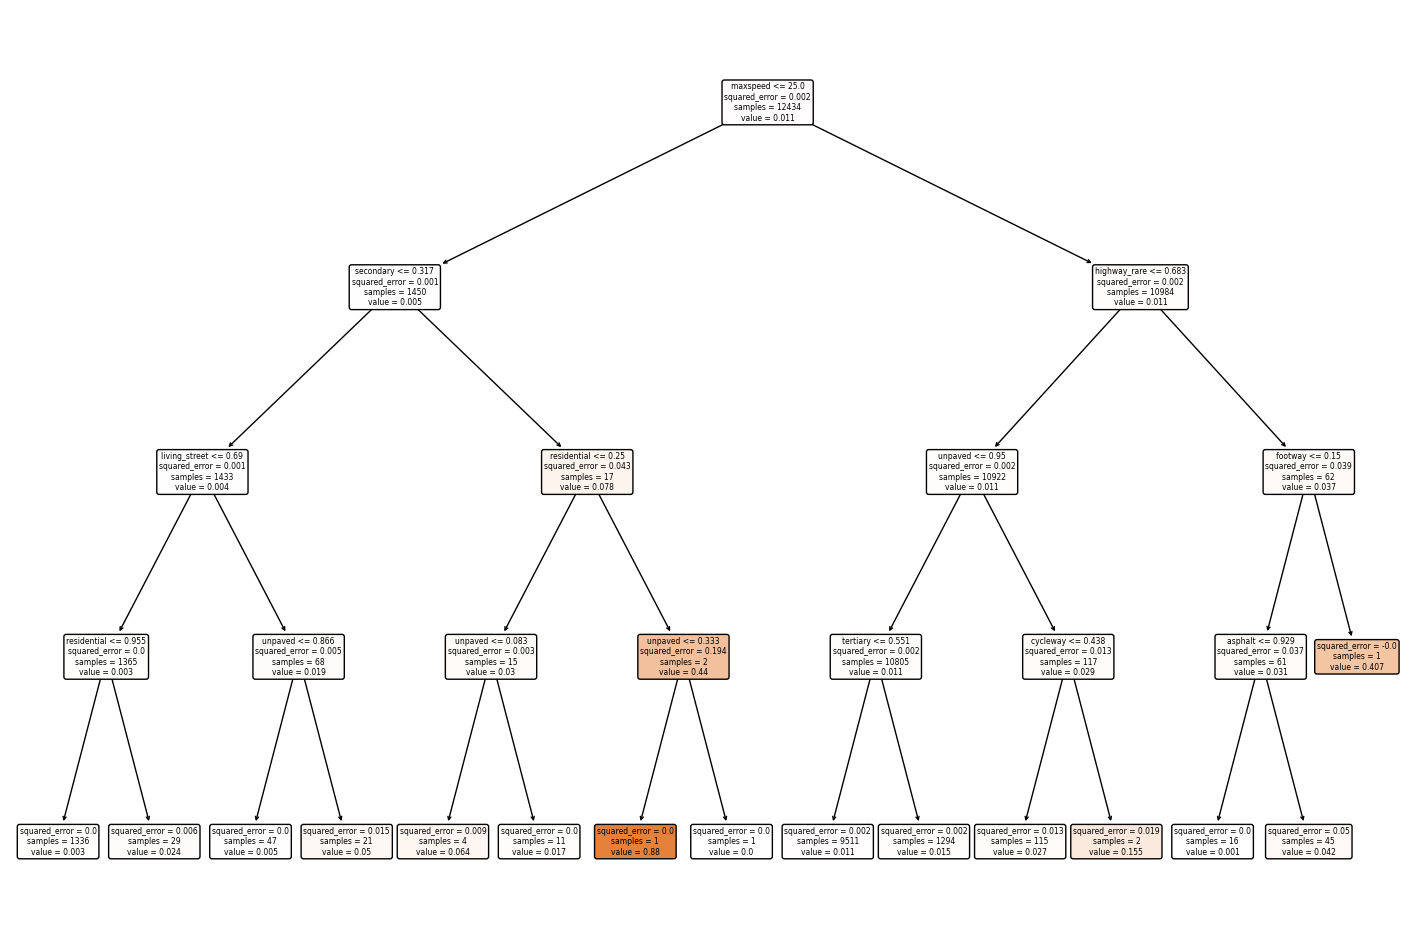

In [15]:
fig = plt.figure(figsize=(18,12))
_ = tree.plot_tree(dt, feature_names=X.columns, filled=True, rounded=True)

### Vorhersage auf den Testdaten

In [17]:
y_pred = dt.predict(X_test)

In [18]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.0015517861263521502


In [19]:
# R²-Score auf den Testdaten berechnen
r2 = r2_score(y_test, y_pred)
print(f'R²-Score auf den Testdaten: {r2}')

R²-Score auf den Testdaten: -0.03773318177721929


### Feature Importance

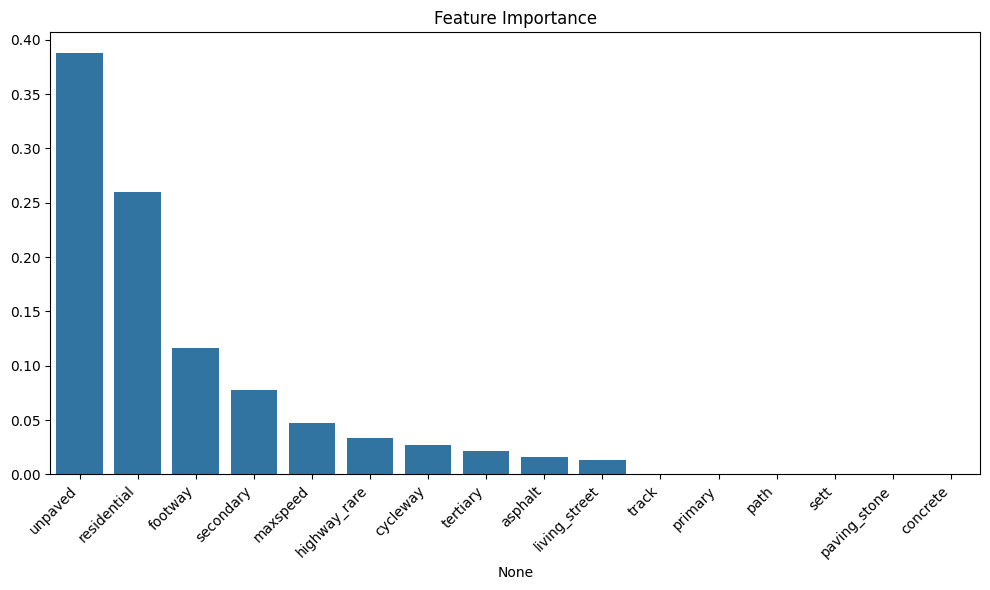

In [21]:
import numpy as np
import seaborn as sns

# Feature Importance extrahieren
importance = dt.feature_importances_

# Sortieren der Features nach Wichtigkeit
sorted_indices = np.argsort(importance)[::-1]

# Plot mit rotierter Achsenbeschriftung
plt.figure(figsize=(10, 6))
sns.barplot(x=X.columns[sorted_indices], y=importance[sorted_indices])
plt.xticks(rotation=45, ha='right')  # Beschriftung um 45 Grad rotieren
plt.title('Feature Importance')
plt.tight_layout()  # Automatische Anpassung des Layouts

## Hyperparametertuning

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor

# Definiere das Modell
model = DecisionTreeRegressor()

# Definiere den Hyperparameter-Raum (inklusive max_features)
param_grid = {
    'max_depth': range(1, 21),  # Baumtiefen
    'min_samples_split': [2, 5, 10, 20],  # minimale Anzahl an Samples für Splits
    'min_samples_leaf': [1, 2, 4, 10],  # minimale Anzahl an Samples in einem Blatt
    'max_features': [None, 'sqrt', 'log2', 0.5]  # Werte für max_features
}

In [23]:
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2')

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 21),
                         'max_features': [None, 'sqrt', 'log2', 0.5],
                         'min_samples_leaf': [1, 2, 4, 10],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='r2')

In [24]:
# Bestes Modell und Parameter
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best Score: {grid_search.best_score_}")
print(f"Best Params: {best_params}")

Best Score: 0.0029976974275558233
Best Params: {'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 20}


### Cross Validation auf Trainingsdaten

In [25]:
from sklearn.model_selection import cross_validate

# Cross-Validation auf Trainingsdaten
scoring = {
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'RMSE': make_scorer(lambda y, y_pred: np.sqrt(mean_squared_error(y, y_pred)))
}

cv_results = cross_validate(grid_search.best_estimator_, X_train, y_train, cv=5, scoring=scoring, return_train_score=True)

print("Durchschnittliche Ergebnisse über die 5 Folds:")
print(f"R^2 Score: {cv_results['test_R2'].mean()}")
print(f"Mean Absolute Error (MAE): {cv_results['test_MAE'].mean()}")
print(f"Mean Squared Error (MSE): {cv_results['test_MSE'].mean()}")
print(f"Root Mean Squared Error (RMSE): {cv_results['test_RMSE'].mean()}")

Durchschnittliche Ergebnisse über die 5 Folds:
R^2 Score: -0.00018611858626640387
Mean Absolute Error (MAE): 0.015745288673474425
Mean Squared Error (MSE): 0.001959480564316808
Root Mean Squared Error (RMSE): 0.04413118974726612


### Bewertung auf Testdaten

In [26]:
# Bewertung auf den Testdaten
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
median_ae = median_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("\nBewertung auf den Testdaten:")
print(f'Mean Squared Error: {mse}')
print(f'R²-Score: {r2}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Median Absolute Error: {median_ae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')


Bewertung auf den Testdaten:
Mean Squared Error: 0.0014919570939547083
R²-Score: 0.0022765664078604475
Mean Absolute Error (MAE): 0.01490868455417953
Median Absolute Error: 0.011015481676018608
Root Mean Squared Error (RMSE): 0.03862586042995946


### Versuch: Skalierung oder Transformation der Zielvariable
#### Log-Transformation


In [27]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Beispiel-Daten
# X, y = deine Daten

# Log-Transformation der Zielvariable
y_log = np.log1p(y)  # np.log1p(y) ist log(1 + y), um negative Werte zu vermeiden

# Daten aufteilen
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=1)

# Modell trainieren
dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)

# Vorhersagen und Rücktransformation
y_pred_log = dt.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Rücktransformation der Vorhersagen

# Metriken berechnen
print(f"R^2 Score: {r2_score(y_test, y_pred)}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test, y_pred)}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred))}")

R^2 Score: -0.0064148467228715145
Mean Absolute Error (MAE): 0.01379006510527371
Mean Squared Error (MSE): 0.0010922118022536537
Root Mean Squared Error (RMSE): 0.033048627842221436


### R²-Wert

Der R²-Wert (Bestimmtheitsmaß) gibt an, wie gut das Modell die Varianz der Zielvariable erklärt. Er liegt im Bereich von 0 bis 1, wobei:
- 1 bedeutet, dass das Modell die gesamte Varianz der Zielvariable perfekt erklärt.
- 0 bedeutet, dass das Modell die Varianz der Zielvariable überhaupt nicht erklärt.

Mit einem R²-Wert von `0.04896516309829968` bedeutet das:
- Dein Modell erklärt nur etwa 4.9% der Varianz der Zielvariable.
- Dies deutet darauf hin, dass die aktuelle Modellkonfiguration wahrscheinlich schlecht an die Daten angepasst ist (Underfitting) oder dass die Beziehung zwischen den Features und der Zielvariable möglicherweise nicht linear ist und nicht durch einen einfachen Entscheidungsbaum modelliert werden kann.

### MSE (Mean Squared Error)

Der Mittlere Quadratische Fehler (MSE) gibt den durchschnittlichen der quadrierten Fehler zwischen den vorhergesagten und den tatsächlichen Werten an. Ein niedrigerer MSE-Wert bedeutet eine bessere Anpassung des Modells. 

Mit einem MSE von `0.0015525934845427116`:
- Dies ist dein Maß für den durchschnittlichen quadratischen Fehler. Ohne den Maßstab der Zielvariable zu kennen, ist es schwer, dies direkt zu interpretieren, aber im Allgemeinen bedeutet ein sehr kleiner MSE-Wert, dass die Fehler relativ klein sind.
- Allerdings muss der MSE im Kontext des Datensatzes und der Skalierung der Zielvariable betrachtet werden.

### Mögliche Verbesserungen:

**1. Datenvorverarbeitung und Merkmalsauswahl:**
- Prüfe, ob alle wichtigen Merkmale (Features) im Datensatz vorhanden sind.
- Betrachte die Möglichkeit, neue relevante Merkmale zu erstellen oder bestehende Merkmale zu transformieren.
- Skaliere die Daten, falls nötig.

**2. Hyperparameter-Tuning:**
- Überlege, andere Hyperparameter des Entscheidungsbaums zu optimieren, nicht nur `maxdepth`, sondern auch `minsamplessplit`, `minsamplesleaf`, `maxfeatures`, etc.
- Grid-Search oder Random-Search könnte hier hilfreich sein.

**3. Komplexere Modelle:**
- Überlege, ob komplexere Modelle wie Random Forests, Gradient Boosting, oder andere nicht-lineare Modelle besser geeignet sein könnten.
- Diese Modelle sind oft besser darin, komplexe Beziehungen in den Daten zu modellieren.

**4. Cross-Validation:**
- Verwende Cross-Validation, um sicherzustellen, dass die Ergebnisse robust sind und nicht auf eine bestimmte Aufteilung von Trainings- und Testdaten beschränkt sind.

#### Grid-Search

In [29]:
from sklearn.model_selection import GridSearchCV

# Definition des Hyperparameter-Rasters
param_grid = {
    'max_depth': [2, 4, 5, 7, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None, 1, 2, 4, 6, 8, 9] 
}

# Initialisieren des Regressors
regressor = DecisionTreeRegressor(random_state=1)

# Grid Search
grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Beste Hyperparameter
best_params = grid_search.best_params_
print(f'Beste Hyperparameter: {best_params}')

# Modell mit besten Hyperparametern erneut trainieren
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error mit besten Hyperparametern: {mse}')

Beste Hyperparameter: {'max_depth': 2, 'max_features': 9, 'min_samples_leaf': 1, 'min_samples_split': 2}
Mean Squared Error mit besten Hyperparametern: 0.0010833782135065875


## Cross Validation
-  Anwendung der K-Fold Cross-Validation, um die Leistung deines Modells zu bewerten

**k-Fold Cross-Validation:**
   - Die Daten werden zufällig in `k` gleich große Untergruppen (Folds) aufgeteilt.
   - Das Modell wird `k` Mal trainiert und validiert. Jedes Mal wird eine der `k` Gruppen als Validierungssatz verwendet und die verbleibenden `k-1` Gruppen als Trainingssatz.
   - Nach `k` Durchläufen werden die Ergebnisse zusammengefasst, um eine Durchschnittsleistung des Modells zu berechnen.

Cross-Validation Anwendung:
   - `KFold` wird verwendet, um K-Fold Cross-Validation einrichten (mit `n_splits=5` für 5 Folds).
   - Wir definieren das Modell (`DecisionTreeRegressor`).
   - Wir verwenden `crossvalscore`, um die Bewertung (MSE in diesem Beispiel) für jedes Fold zu berechnen.
   - Die Ergebnisse werden umgerechnet (negative MSE zu positiven MSE) und der Durchschnitt berechnet.
   - Optional: Wir berechnen zusätzlich die R²-Werte für jeden Fold und den durchschnittlichen R²-Wert.

Durch die Anwendung von Cross-Validation erhälten wir eine robustere Schätzung der Modellleistung als durch eine einfache Aufteilung der Daten in Trainings- und Testdaten. Dies hilft dabei sicherzustellen, dass unser Modell gut verallgemeinert und nicht nur gut auf den Trainingsdaten performt.

In [30]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score, KFold

In [31]:
# Features definieren (X) und Zielvariable (y)
y = df['score']
X = df.drop(columns=['score'])

# 2. Cross-Validation Anwendung
# K-Fold Cross-Validation instanziieren
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Entscheidungsbaum-Regressor definieren
model = DecisionTreeRegressor()

# Cross-Val-Score berechnen
scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')

# MSE-Werte und durchschnittlichen MSE ausgeben
mse_scores = -scores
mean_mse = mse_scores.mean()

print("MSE für jeden Fold: ", mse_scores)
print("Durchschnittlicher MSE: ", mean_mse)

# Optional: R²-Werte berechnen
r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
mean_r2 = r2_scores.mean()

print("R² für jeden Fold: ", r2_scores)
print("Durchschnittlicher R²: ", mean_r2)

MSE für jeden Fold:  [0.00199983 0.00249408 0.00209416 0.00295864 0.00221293]
Durchschnittlicher MSE:  0.002351927195505014
R² für jeden Fold:  [-0.38487975 -0.37915675 -0.30544887 -0.20122074 -0.13249298]
Durchschnittlicher R²:  -0.28063981830046947


In [32]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [33]:
X = df.drop(columns='score')
y = df['score']

regressor = DecisionTreeRegressor(random_state=1)

# Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=1)
cv_scores = cross_val_score(regressor, X, y, cv=kf, scoring='neg_mean_squared_error')
mse_scores = -cv_scores  
# Negatives MSE in positives MSE umwandeln

# Durchschnitt und Standardabweichung der MSE
mean_mse = mse_scores.mean()
std_mse = mse_scores.std()

print(f'Mean Squared Error (Durchschnitt): {mean_mse}')
print(f'Mean Squared Error (Standardabweichung): {std_mse}')

Mean Squared Error (Durchschnitt): 0.0023021213192110724
Mean Squared Error (Standardabweichung): 0.00034617289969571794


In [34]:
r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
mean_r2 = r2_scores.mean()

In [35]:
print("R² für jeden Fold: ", r2_scores)
print("Durchschnittlicher R²: ", mean_r2)

R² für jeden Fold:  [-0.2996868  -0.33363958 -0.29675039 -0.18459513 -0.13801643]
Durchschnittlicher R²:  -0.25053766649851006
